In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clean
import process

# import pytorchPipeline
import pandas as pd
import numpy as np
import train_test_split
import scipy as sp

In [2]:
def get_ratings(style="range", threshold=2.5):
    """Gets the ratings/interaction/user-item matrix
    in the form we need to apply the model.

    Parameters
    ----------
    style: str, optional
        Options: 'range', 'pos_neg', 'zero_one'
        The format of the ratings matrix (see process.py)
        Defaults to 'range'
    threshold: int, optional
        The cutoff threshold for "liking" a beer; only
        matters if style = 'pos_neg' or style = 'zero_one'
        (see process.py)
        Defaults to 2.5
    """
    if style not in ["range", "pos_neg", "zero_one"]:
        raise Exception("Not a valid choice for style.")

    reviews = pd.read_csv(
        "https://query.data.world/s/55cb4g2ccy2sbat45jzrwmfjfkp2d5?dws=00000"
    )
    reviews.review_time = pd.to_datetime(reviews.review_time, unit="s")
    clean_reviews = clean.remove_null_rows(reviews)
    clean_reviews = clean.remove_dup_beer_rows(clean_reviews)
    clean_reviews = clean.merge_similar_name_breweries(clean_reviews)
    clean_reviews = clean.merge_brewery_ids(clean_reviews)

    if style == "range":
        return process.InteractionMatrixTransformer(clean_reviews).to_range().tocsr()
    if style == "pos_neg":
        return (
            process.InteractionMatrixTransformer(clean_reviews)
            .to_positive_negative(threshold)
            .tocsr()
        )
    if style == "zero_one":
        return (
            process.InteractionMatrixTransformer(clean_reviews)
            .to_zero_one(threshold)
            .tocsr()
        )

In [3]:
class MatrixFactorization(torch.nn.Module):
    """Matrix factorization model.

    - Initializes user and item embeddings (default to dimension 10).
    - Forward pass is just a dot product between user and item latent vectors.
    """

    def __init__(self, num_users, num_items, emb_size=10):
        super().__init__()
        self.user_emb = torch.nn.Embedding(num_users, emb_size)
        self.item_emb = torch.nn.Embedding(num_items, emb_size)
        # initializing weights
        self.user_emb.weight.data.uniform_(0, 1)
        self.item_emb.weight.data.uniform_(0, 1)

    def forward(self, user, item):
        return (self.user_emb(user) * self.item_emb(item)).sum(1)

In [4]:
def train_epochs(model, int_matrix, epochs=10, lr=0.001, wd=0.0):
    """Trains the matrix factorization model.

    Parameters
    ----------
    model: MatrixFactorization
        The instance of a matrix factorization model to train
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    epochs: int, optional
        Number of epochs in training
        Default is 10
    lr: float, optional
        Learning rate
        Default is 0.001
    wd: float, optional
        Weight decay
        Default is 0.0
    """
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=wd
    )  # learning rate
    for i in range(epochs):
        model.train()  # put model in training mode (?)

        # Set gradients to zero
        optimizer.zero_grad()

        # Get mse for nonzero entries
        (
            rows,
            cols,
        ) = int_matrix.nonzero()  # (rows[i], cols[i]) across all i will be the coordinates of all nonzero entries of ratings.

        pred = model(torch.tensor(rows), torch.tensor(cols))
        actual = torch.tensor(
            int_matrix[rows, cols], dtype=torch.float32
        ).squeeze()  # squeeze just reshapes to the appropriate dim

        loss = F.mse_loss(pred, actual)

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        print("After %.0f epochs, train loss %.10f" % (i + 1, loss.item()))
    print("Final RMSE: %.4f" % loss.item() ** (1 / 2))

In [43]:
def standard_training(
    model, int_matrix, initial_lr=0.01, decay_rate=0.98, epochs=500, wd=0.0
):
    """Standardizes training for matrix factorization
    models with learning rate decaying as:
    initial_lr * decay_rate^epoch
    Stick to the default inputs to standardize training!

    Parameters
    ----------
    model: MatrixFactorization
        The instance of a matrix factorization model to train
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    epochs: int, optional
        Number of epochs in training
        Default is 10
    initial_lr: float, optional
        Learning rate
        Default is 0.01
    decay_rate: float, optional
        Decay rate
        Default is 1.0
    wd: float, optional
        Weight decay
        Default is 0.0
    """
    model.train()  # put model in training mode (?)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
    for i in range(epochs):
        # Set gradients to zero
        optimizer.zero_grad()

        # Get mse for nonzero entries
        (
            rows,
            cols,
        ) = int_matrix.nonzero()  # (rows[i], cols[i]) across all i will be the coordinates of all nonzero entries of ratings.

        pred = model(torch.tensor(rows), torch.tensor(cols))
        actual = torch.tensor(
            int_matrix[rows, cols], dtype=torch.float32
        ).squeeze()  # squeeze just reshapes to the appropriate dim

        loss = F.mse_loss(pred, actual)

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        scheduler.step()

        if i % 10 == 0:
            print("After %.0f epochs, train loss %.10f" % (i, loss.item()))
    print("Final RMSE: %.4f" % loss.item() ** (1 / 2))

In [6]:
int_matrix = get_ratings()

In [7]:
def recall_at_k_range(model, int_matrix, user, threshold=2.5, k=10):
    """Compute recall at k for a given user in the case
    where the ratings matrix was built using to_range.
    This is the ratio of number of items the user
    actually liked (determined by threshold) in the
    top k predictions made by the model over the total
    number of items the user actually liked.

    Parameters
    ----------
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    user: int
        The index of the user for whom you want to compute recall at k
    threshold: float, optional
        The threshold used to determine if a user actually likes a beer
        Defaults to 2.5
    k: int, optional
        The k parameter
        Defaults to 10
    """
    num_items = int_matrix.shape[1]
    preds = model(
        torch.tensor(user), torch.arange(num_items)
    )  # predicated ratings of all beers
    topk_inds = torch.topk(preds, k).indices  # indices of the top k predictions

    # get indices of the liked beers
    x = torch.tensor(int_matrix[user].toarray()).squeeze()
    inds_of_liked_beers = (
        torch.where(x > threshold, 1, 0).squeeze().nonzero()
    )  # puts 1 in indices where x > thresh, 0 else then gets the nonzero indices

    if inds_of_liked_beers.shape[0] == 0:
        # return 'no liked beers'
        return 1, 0  # is this how this should go??

    intersect = np.intersect1d(topk_inds, inds_of_liked_beers)
    # print(len(intersect), len(inds_of_liked_beers))
    return len(intersect) / min(k, len(inds_of_liked_beers)), len(inds_of_liked_beers)

In [8]:
def recall_at_k_nonrange(model, int_matrix, user, k=10):
    """Compute recall at k for a given user in the case
    where the ratings matrix was built using to_zero_one
    or to_positive_negative. This is the ratio of number
    of items the user actually liked (appear with 1 for
    this user in the ratings matrix) in the top k predictions
    made by the model over the total number of items the user
    actually liked.

    Parameters
    ----------
    model: MatrixFactorization
        The instance of a matrix factorization model to be evaluated
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    user: int
        The index of the user for whom you want to compute recall at k
    k: int, optional
        The k parameter
        Defaults to 10
    """
    num_items = int_matrix.shape[1]
    preds = model(
        torch.tensor(user), torch.arange(num_items)
    )  # predicated ratings of all beers
    topk_inds = torch.topk(preds, k).indices  # indices of the top k predictions

    # get indices of the liked beers
    x = torch.tensor(int_matrix[user].toarray())
    inds_of_liked_beers = (
        torch.where(x == 1, 1, 0).squeeze().nonzero()
    )  # puts 1 in indices where x == 1, 0 else then gets the nonzero indices

    if inds_of_liked_beers.shape[0] == 0:
        # return 'no liked beers'
        return 1  # is this how this should be handled??

    intersect = np.intersect1d(topk_inds, inds_of_liked_beers)

    return len(intersect) / min(
        k, len(inds_of_liked_beers)
    )  # we use len(inds_of_liked_beers) for the weighted avg part below.

In [9]:
def get_submatrix(original_matrix, indices):
    rows = indices[:, 0]
    cols = indices[:, 1]
    original_matrix_coo = sp.sparse.coo_matrix(original_matrix)
    new_indices = np.where(
        (np.isin(original_matrix_coo.row, rows))
        & (np.isin(original_matrix_coo.col, cols))
    )
    return sp.sparse.coo_matrix(
        (
            original_matrix_coo.data[new_indices],
            (
                original_matrix_coo.row[new_indices],
                original_matrix_coo.col[new_indices],
            ),
        ),
        shape=original_matrix.shape,
    )

In [10]:
def run_model_with_validation(int_matrix, threshold=2.5, k=10, latent_dim=10):
    recall_vals = [0] * 5
    preds = [0] * 5
    num_users = int_matrix.shape[0]
    num_items = int_matrix.shape[1]
    i = 0
    for train, test in train_test_split.get_splits(int_matrix):
        print("Pass %d" % i)

        model = MatrixFactorization(num_users, num_items, emb_size=latent_dim)

        train_matrix = get_submatrix(int_matrix, train).tocsr()
        test_matrix = get_submatrix(int_matrix, test).tocsr()

        standard_training(model, train_matrix)
        # preds = model(torch.tensor(0), torch.arange(num_items)) # THIS DOESN'T SEEM RIGHT! THIS IS ONLY PREDICTING ON USER 0!
        # topk_inds = torch.topk(preds, k).indices
        recall = total_weighted_recall_at_k_range(
            model, sp.sparse.csr_matrix(test_matrix), threshold=threshold, k=k
        )
        print("Recall: " + str(recall))
        recall_vals[i] = recall
        i += 1
    return recall_vals

In [11]:
def total_weighted_recall_at_k_range(model, int_matrix, threshold=2.5, k=10):
    """Compute total weighted recall at k for a given model
    in the case where the ratings matrix was built using
    to_range. This is the weighted (by total number of liked
    beers for a given user) average of the recall_at_k_range
    for each user.

    Parameters
    ----------
    model: MatrixFactorization
        The instance of a matrix factorization model to be evaluated
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    threshold: float, optional
        The threshold used to determine if a user actually likes a beer
        Defaults to 2.5
    k: int, optional
        The k parameter
        Defaults to 10
    """
    num_users, num_items = int_matrix.shape

    recalls = torch.empty(num_users)
    weights = torch.empty(num_users)

    for user in range(num_users):
        recall_output = recall_at_k_range(model, int_matrix, user, threshold, k)
        recalls[user] = recall_output[0]
        weights[user] = recall_output[1]

    return (recalls * weights / weights.sum()).sum()

### Example code for subsetting a sparse matrix

In [12]:
import numpy as np
from scipy.sparse import coo_matrix

# Example row, column, and data arrays
rows = np.array([0, 1, 2, 1, 3])
cols = np.array([1, 2, 2, 0, 3])
data = np.array([4.2, 3.1, 1.5, 2.3, 5.7])

# Create the original sparse matrix
original_matrix = coo_matrix((data, (rows, cols)))
print(original_matrix.toarray())
# Specify the desired row and column indices for the subset
desired_rows = [1, 3]
desired_cols = [2, 3]

# Find the indices of non-zero elements in the specified rows and columns
subset_indices = np.where(
    (np.isin(original_matrix.row, desired_rows))
    & (np.isin(original_matrix.col, desired_cols))
)

# Extract the subset of the sparse matrix
subset_matrix = coo_matrix(
    (
        original_matrix.data[subset_indices],
        (original_matrix.row[subset_indices], original_matrix.col[subset_indices]),
    ),
    shape=original_matrix.shape,
)

print(subset_matrix.toarray())

[[0.  4.2 0.  0. ]
 [2.3 0.  3.1 0. ]
 [0.  0.  1.5 0. ]
 [0.  0.  0.  5.7]]
[[0.  0.  0.  0. ]
 [0.  0.  3.1 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  5.7]]


In [13]:
def grid_search(latent_dims):  # latent dims is a list
    outs = [[] for _ in range(len(latent_dims))]
    # add other hyperparams to gridsearch over?
    for i, latent_dim in enumerate(latent_dims):
        outs[i].append(latent_dim)
        cross_vals = run_model_with_validation(
            int_matrix, threshold=2.5, k=10, latent_dim=latent_dim
        )
        outs[i].append(cross_vals)
        outs[i].append(sum(cross_vals) / len(cross_vals))
    return outs

In [44]:
grid_res = grid_search([5, 10, 20, 30, 50, 75, 100, 150])
grid_res

Pass 0
After 0 epochs, train loss 7.7158036232
After 10 epochs, train loss 5.4535336494
After 20 epochs, train loss 3.7970621586
After 30 epochs, train loss 2.6976013184
After 40 epochs, train loss 2.0144870281
After 50 epochs, train loss 1.5988513231
After 60 epochs, train loss 1.3413809538
After 70 epochs, train loss 1.1757620573
After 80 epochs, train loss 1.0647454262
After 90 epochs, train loss 0.9875039458
After 100 epochs, train loss 0.9320409894
After 110 epochs, train loss 0.8911648393
After 120 epochs, train loss 0.8603902459
After 130 epochs, train loss 0.8368143439
After 140 epochs, train loss 0.8184958100
After 150 epochs, train loss 0.8040974140
After 160 epochs, train loss 0.7926735878
After 170 epochs, train loss 0.7835404277
After 180 epochs, train loss 0.7761932611
After 190 epochs, train loss 0.7702529430
After 200 epochs, train loss 0.7654306293
After 210 epochs, train loss 0.7615028620
After 220 epochs, train loss 0.7582953572
After 230 epochs, train loss 0.7556703

After 430 epochs, train loss 0.7454228997
After 440 epochs, train loss 0.7453783751
After 450 epochs, train loss 0.7453418374
After 460 epochs, train loss 0.7453116179
After 470 epochs, train loss 0.7452869415
After 480 epochs, train loss 0.7452666163
After 490 epochs, train loss 0.7452499270
Final RMSE: 0.8633
Recall: tensor(0.)
Pass 4
After 0 epochs, train loss 7.7116580009
After 10 epochs, train loss 5.4492239952
After 20 epochs, train loss 3.7928190231
After 30 epochs, train loss 2.6935372353
After 40 epochs, train loss 2.0110001564
After 50 epochs, train loss 1.5961890221
After 60 epochs, train loss 1.3395183086
After 70 epochs, train loss 1.1745560169
After 80 epochs, train loss 1.0640444756
After 90 epochs, train loss 0.9871822596
After 100 epochs, train loss 0.9320022464
After 110 epochs, train loss 0.8913378119
After 120 epochs, train loss 0.8607226014
After 130 epochs, train loss 0.8372677565
After 140 epochs, train loss 0.8190422654
After 150 epochs, train loss 0.8047160506


After 350 epochs, train loss 0.4963162243
After 360 epochs, train loss 0.4962997139
After 370 epochs, train loss 0.4962860942
After 380 epochs, train loss 0.4962748289
After 390 epochs, train loss 0.4962655604
After 400 epochs, train loss 0.4962579310
After 410 epochs, train loss 0.4962514937
After 420 epochs, train loss 0.4962462187
After 430 epochs, train loss 0.4962419868
After 440 epochs, train loss 0.4962383509
After 450 epochs, train loss 0.4962354302
After 460 epochs, train loss 0.4962329865
After 470 epochs, train loss 0.4962310195
After 480 epochs, train loss 0.4962293208
After 490 epochs, train loss 0.4962280095
Final RMSE: 0.7044
Recall: tensor(0.)
Pass 3
After 0 epochs, train loss 3.0246081352
After 10 epochs, train loss 1.3459948301
After 20 epochs, train loss 0.8257319331
After 30 epochs, train loss 0.6457535625
After 40 epochs, train loss 0.5760325193
After 50 epochs, train loss 0.5457618833
After 60 epochs, train loss 0.5302664042
After 70 epochs, train loss 0.521388113

After 270 epochs, train loss 0.4868214130
After 280 epochs, train loss 0.4867017567
After 290 epochs, train loss 0.4866026938
After 300 epochs, train loss 0.4865205884
After 310 epochs, train loss 0.4864526093
After 320 epochs, train loss 0.4863963127
After 330 epochs, train loss 0.4863497615
After 340 epochs, train loss 0.4863111973
After 350 epochs, train loss 0.4862793088
After 360 epochs, train loss 0.4862529933
After 370 epochs, train loss 0.4862311780
After 380 epochs, train loss 0.4862131476
After 390 epochs, train loss 0.4861982465
After 400 epochs, train loss 0.4861859083
After 410 epochs, train loss 0.4861757457
After 420 epochs, train loss 0.4861674309
After 430 epochs, train loss 0.4861605167
After 440 epochs, train loss 0.4861547649
After 450 epochs, train loss 0.4861500561
After 460 epochs, train loss 0.4861461520
After 470 epochs, train loss 0.4861429632
After 480 epochs, train loss 0.4861403108
After 490 epochs, train loss 0.4861381054
Final RMSE: 0.6972
Recall: tensor(

After 190 epochs, train loss 0.6064770818
After 200 epochs, train loss 0.6055467725
After 210 epochs, train loss 0.6047773957
After 220 epochs, train loss 0.6041402817
After 230 epochs, train loss 0.6036123633
After 240 epochs, train loss 0.6031745672
After 250 epochs, train loss 0.6028113961
After 260 epochs, train loss 0.6025100350
After 270 epochs, train loss 0.6022599936
After 280 epochs, train loss 0.6020524502
After 290 epochs, train loss 0.6018802524
After 300 epochs, train loss 0.6017373204
After 310 epochs, train loss 0.6016187668
After 320 epochs, train loss 0.6015203595
After 330 epochs, train loss 0.6014388204
After 340 epochs, train loss 0.6013712287
After 350 epochs, train loss 0.6013151407
After 360 epochs, train loss 0.6012686491
After 370 epochs, train loss 0.6012302041
After 380 epochs, train loss 0.6011983156
After 390 epochs, train loss 0.6011718512
After 400 epochs, train loss 0.6011499763
After 410 epochs, train loss 0.6011319160
After 420 epochs, train loss 0.601

After 110 epochs, train loss 0.6305670738
After 120 epochs, train loss 0.6254999638
After 130 epochs, train loss 0.6214887500
After 140 epochs, train loss 0.6182740331
After 150 epochs, train loss 0.6156743169
After 160 epochs, train loss 0.6135578752
After 170 epochs, train loss 0.6118263006
After 180 epochs, train loss 0.6104041934
After 190 epochs, train loss 0.6092330813
After 200 epochs, train loss 0.6082664132
After 210 epochs, train loss 0.6074671745
After 220 epochs, train loss 0.6068056226
After 230 epochs, train loss 0.6062576175
After 240 epochs, train loss 0.6058031917
After 250 epochs, train loss 0.6054263711
After 260 epochs, train loss 0.6051136851
After 270 epochs, train loss 0.6048542261
After 280 epochs, train loss 0.6046389341
After 290 epochs, train loss 0.6044602394
After 300 epochs, train loss 0.6043120623
After 310 epochs, train loss 0.6041890979
After 320 epochs, train loss 0.6040870547
After 330 epochs, train loss 0.6040024757
After 340 epochs, train loss 0.603

After 30 epochs, train loss 3.1568825245
After 40 epochs, train loss 1.9038653374
After 50 epochs, train loss 1.4755847454
After 60 epochs, train loss 1.2856581211
After 70 epochs, train loss 1.1801937819
After 80 epochs, train loss 1.1125078201
After 90 epochs, train loss 1.0652793646
After 100 epochs, train loss 1.0306591988
After 110 epochs, train loss 1.0044738054
After 120 epochs, train loss 0.9842387438
After 130 epochs, train loss 0.9683552384
After 140 epochs, train loss 0.9557381272
After 150 epochs, train loss 0.9456222653
After 160 epochs, train loss 0.9374520779
After 170 epochs, train loss 0.9308143854
After 180 epochs, train loss 0.9253964424
After 190 epochs, train loss 0.9209574461
After 200 epochs, train loss 0.9173094034
After 210 epochs, train loss 0.9143042564
After 220 epochs, train loss 0.9118241072
After 230 epochs, train loss 0.9097741246
After 240 epochs, train loss 0.9080778956
After 250 epochs, train loss 0.9066729546
After 260 epochs, train loss 0.9055085182

After 460 epochs, train loss 1.6844992638
After 470 epochs, train loss 1.6843963861
After 480 epochs, train loss 1.6843110323
After 490 epochs, train loss 1.6842405796
Final RMSE: 1.2978
Recall: tensor(0.0002)
Pass 2
After 0 epochs, train loss 225.5435485840
After 10 epochs, train loss 80.8747177124
After 20 epochs, train loss 30.6253719330
After 30 epochs, train loss 13.7871551514
After 40 epochs, train loss 7.6914353371
After 50 epochs, train loss 5.1579160690
After 60 epochs, train loss 3.9324758053
After 70 epochs, train loss 3.2537624836
After 80 epochs, train loss 2.8357043266
After 90 epochs, train loss 2.5575656891
After 100 epochs, train loss 2.3622136116
After 110 epochs, train loss 2.2196433544
After 120 epochs, train loss 2.1126503944
After 130 epochs, train loss 2.0306563377
After 140 epochs, train loss 1.9667959213
After 150 epochs, train loss 1.9164209366
After 160 epochs, train loss 1.8762774467
After 170 epochs, train loss 1.8440253735
After 180 epochs, train loss 1.81

After 370 epochs, train loss 3.7492964268
After 380 epochs, train loss 3.7474830151
After 390 epochs, train loss 3.7459802628
After 400 epochs, train loss 3.7447361946
After 410 epochs, train loss 3.7437057495
After 420 epochs, train loss 3.7428526878
After 430 epochs, train loss 3.7421464920
After 440 epochs, train loss 3.7415623665
After 450 epochs, train loss 3.7410788536
After 460 epochs, train loss 3.7406785488
After 470 epochs, train loss 3.7403478622
After 480 epochs, train loss 3.7400746346
After 490 epochs, train loss 3.7398486137
Final RMSE: 1.9338
Recall: tensor(0.0005)
Pass 1
After 0 epochs, train loss 454.2557067871
After 10 epochs, train loss 174.9907226562
After 20 epochs, train loss 72.3816986084
After 30 epochs, train loss 35.2170906067
After 40 epochs, train loss 20.5597553253
After 50 epochs, train loss 13.9652824402
After 60 epochs, train loss 10.5650281906
After 70 epochs, train loss 8.5923271179
After 80 epochs, train loss 7.3383316994
After 90 epochs, train loss 

After 280 epochs, train loss 3.8450121880
After 290 epochs, train loss 3.8350141048
After 300 epochs, train loss 3.8267283440
After 310 epochs, train loss 3.8198583126
After 320 epochs, train loss 3.8141627312
After 330 epochs, train loss 3.8094413280
After 340 epochs, train loss 3.8055269718
After 350 epochs, train loss 3.8022820950
After 360 epochs, train loss 3.7995927334
After 370 epochs, train loss 3.7973639965
After 380 epochs, train loss 3.7955172062
After 390 epochs, train loss 3.7939872742
After 400 epochs, train loss 3.7927205563
After 410 epochs, train loss 3.7916710377
After 420 epochs, train loss 3.7908022404
After 430 epochs, train loss 3.7900836468
After 440 epochs, train loss 3.7894883156
After 450 epochs, train loss 3.7889962196
After 460 epochs, train loss 3.7885882854
After 470 epochs, train loss 3.7882518768
After 480 epochs, train loss 3.7879731655
After 490 epochs, train loss 3.7877430916
Final RMSE: 1.9462
Recall: tensor(0.0008)
Pass 0
After 0 epochs, train loss 

After 160 epochs, train loss 14.8947000504
After 170 epochs, train loss 14.5160064697
After 180 epochs, train loss 14.2084321976
After 190 epochs, train loss 13.9574861526
After 200 epochs, train loss 13.7519989014
After 210 epochs, train loss 13.5832443237
After 220 epochs, train loss 13.4443340302
After 230 epochs, train loss 13.3297729492
After 240 epochs, train loss 13.2351589203
After 250 epochs, train loss 13.1569318771
After 260 epochs, train loss 13.0921945572
After 270 epochs, train loss 13.0385894775
After 280 epochs, train loss 12.9941787720
After 290 epochs, train loss 12.9573755264
After 300 epochs, train loss 12.9268693924
After 310 epochs, train loss 12.9015827179
After 320 epochs, train loss 12.8806152344
After 330 epochs, train loss 12.8632373810
After 340 epochs, train loss 12.8488340378
After 350 epochs, train loss 12.8368949890
After 360 epochs, train loss 12.8270006180
After 370 epochs, train loss 12.8188066483
After 380 epochs, train loss 12.8120155334
After 390 e

[[5,
  [tensor(0.), tensor(0.), tensor(0.0002), tensor(0.), tensor(0.)],
  tensor(3.1877e-05)],
 [10,
  [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)],
  tensor(0.)],
 [20,
  [tensor(4.7285e-05),
   tensor(0.),
   tensor(0.0002),
   tensor(6.0606e-05),
   tensor(0.0002)],
  tensor(9.8443e-05)],
 [30,
  [tensor(0.0001),
   tensor(0.0002),
   tensor(0.0003),
   tensor(6.0606e-05),
   tensor(0.0003)],
  tensor(0.0002)],
 [50,
  [tensor(0.0004),
   tensor(0.0003),
   tensor(0.0004),
   tensor(0.0003),
   tensor(0.0007)],
  tensor(0.0004)],
 [75,
  [tensor(0.0007),
   tensor(0.0002),
   tensor(0.0004),
   tensor(0.0008),
   tensor(0.0003)],
  tensor(0.0005)],
 [100,
  [tensor(0.0005),
   tensor(0.0003),
   tensor(0.0011),
   tensor(0.0006),
   tensor(0.0008)],
  tensor(0.0007)],
 [150,
  [tensor(0.0013),
   tensor(0.0005),
   tensor(0.0005),
   tensor(0.0003),
   tensor(0.0006)],
  tensor(0.0006)]]

In [53]:
vals = [grid_res[i][2] for i in range(8)]

In [54]:
vals

[tensor(3.1877e-05),
 tensor(0.),
 tensor(9.8443e-05),
 tensor(0.0002),
 tensor(0.0004),
 tensor(0.0005),
 tensor(0.0007),
 tensor(0.0006)]

In [49]:
import matplotlib.pyplot as plt

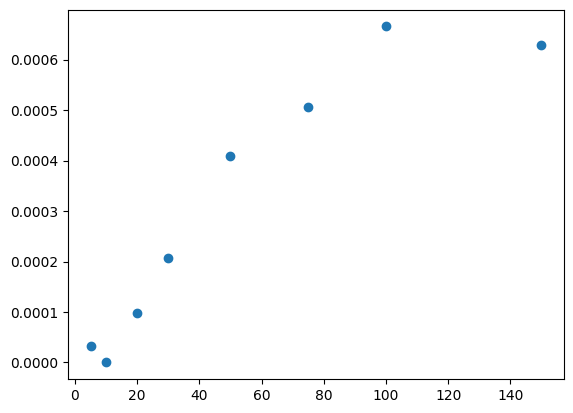

In [55]:
plt.scatter([5, 10, 20, 30, 50, 75, 100, 150], vals)

In [29]:
grid_res.append(grid_search([150]))

Pass 0
After 0 epochs, train loss 1137.6674804688
After 10 epochs, train loss 465.6464538574
After 20 epochs, train loss 207.5178527832
After 30 epochs, train loss 108.3490600586
After 40 epochs, train loss 66.7000961304
After 50 epochs, train loss 46.8476905823
After 60 epochs, train loss 36.1109924316
After 70 epochs, train loss 29.6495342255
After 80 epochs, train loss 25.4295082092
After 90 epochs, train loss 22.5049686432
After 100 epochs, train loss 20.3904743195
After 110 epochs, train loss 18.8140182495
After 120 epochs, train loss 17.6115913391
After 130 epochs, train loss 16.6783561707
After 140 epochs, train loss 15.9441471100
After 150 epochs, train loss 15.3602752686
After 160 epochs, train loss 14.8919439316
After 170 epochs, train loss 14.5136775970
After 180 epochs, train loss 14.2064456940
After 190 epochs, train loss 13.9557809830
Final RMSE: 3.7107
Recall: tensor(0.0005)
Pass 1
After 0 epochs, train loss 1134.7322998047
After 10 epochs, train loss 464.0886840820
Afte

In [30]:
grid_res

[[5, [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)], tensor(0.)],
 [10,
  [tensor(1.1330e-06), tensor(0.), tensor(0.), tensor(8.4032e-05), tensor(0.)],
  tensor(1.7033e-05)],
 [20,
  [tensor(0.), tensor(0.0001), tensor(0.0002), tensor(0.), tensor(0.)],
  tensor(5.1423e-05)],
 [30,
  [tensor(5.7030e-05),
   tensor(0.0004),
   tensor(0.0002),
   tensor(0.),
   tensor(0.0001)],
  tensor(0.0002)],
 [50,
  [tensor(0.0005),
   tensor(0.0007),
   tensor(0.0006),
   tensor(0.0003),
   tensor(0.0010)],
  tensor(0.0006)],
 [75,
  [tensor(0.0006),
   tensor(0.0004),
   tensor(0.0008),
   tensor(0.0009),
   tensor(0.0005)],
  tensor(0.0006)],
 [100,
  [tensor(0.0003),
   tensor(0.0004),
   tensor(0.0007),
   tensor(0.0017),
   tensor(0.0006)],
  tensor(0.0007)],
 [[150,
   [tensor(0.0005),
    tensor(0.0006),
    tensor(0.0004),
    tensor(0.0009),
    tensor(0.0003)],
   tensor(0.0005)]]]

In [37]:
vals = [grid_res[i][2] for i in range(7)]

In [39]:
vals.append(grid_res[7][0][2])

In [40]:
vals

[tensor(0.),
 tensor(1.7033e-05),
 tensor(5.1423e-05),
 tensor(0.0002),
 tensor(0.0006),
 tensor(0.0006),
 tensor(0.0007),
 tensor(0.0005)]

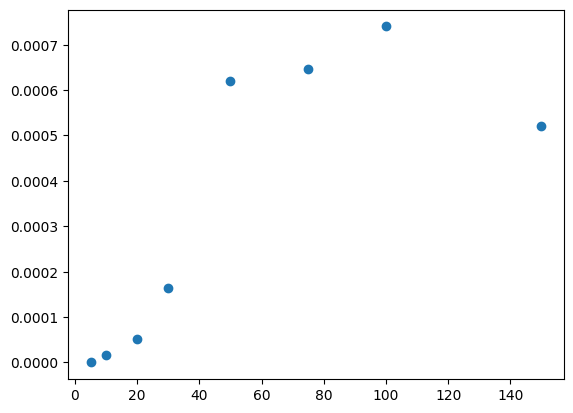

In [41]:
plt.scatter([5, 10, 20, 30, 50, 75, 100, 150], vals)